In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Partie 1 : Analyse exploratoire des données

In [28]:
data = pd.DataFrame({
    'poids': np.random.normal(2.5, 0.5, 100),
    'nourriture': np.random.normal(1.2, 0.3, 100),
    'température': np.random.normal(25, 2, 100)
})

data.head()

,poids,nourriture,température
0,3.041505,0.824184,24.826672
1,2.789152,1.132088,23.322881
2,1.914510,1.249555,21.867848
3,2.231924,1.719257,28.779549
4,3.282356,0.906272,24.557703


## Exercice 1 : Statistiques descriptives (1 points)

### 1. (0.5 pts) Calculez la moyenne, médiane, écart-type, variance et les quartiles pour les variables poids, nourriture et température.

In [29]:
data.describe()

,poids,nourriture,température
count,100.000000,100.000000,100.000000
mean,2.468167,1.253729,24.930454
std,0.521514,0.304479,2.149500
min,0.935018,0.508193,20.241252
25%,2.150886,1.092916,23.613774
50%,2.461643,1.231140,24.978498
75%,2.765581,1.478278,26.460951
max,3.757308,1.946443,29.143161


### 2. (0.5 pts) Tracez des histogrammes et des boxplots pour visualiser la répartition des données. Que pouvez-vous déduire de ces graphiques ? Les données semblent-elles homogènes ou  dispersées ?

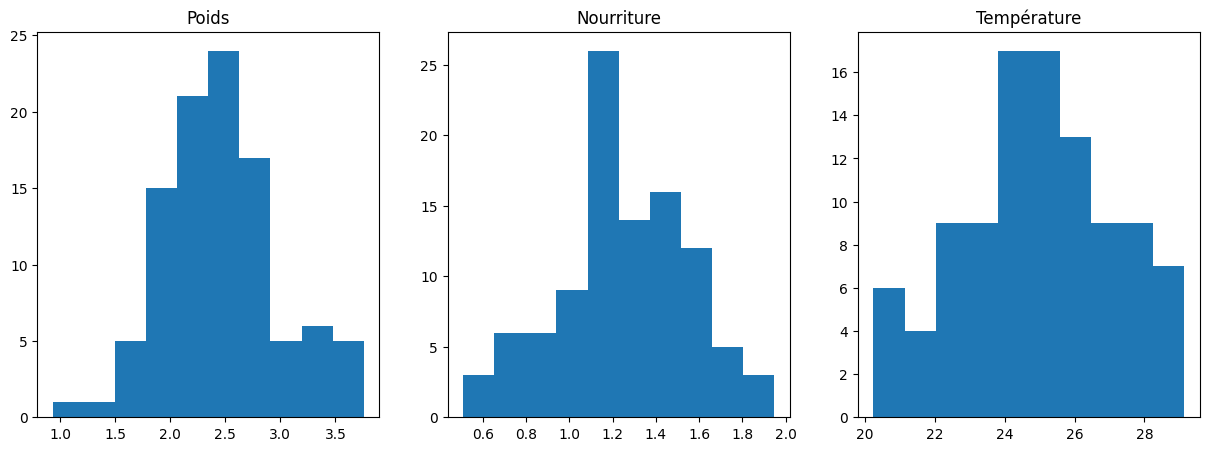

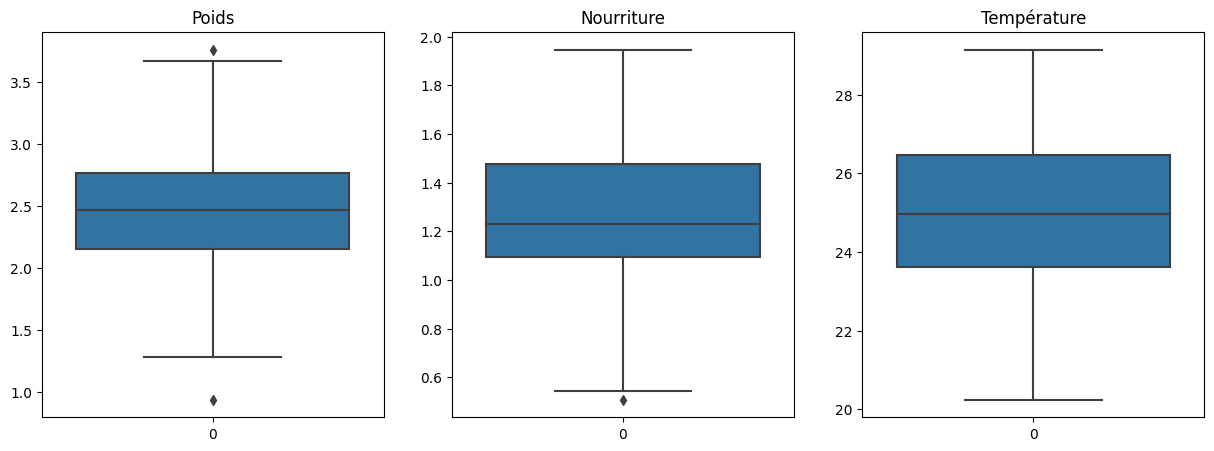

In [30]:
# Histogrammes
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(data['poids'], bins=10)
plt.title('Poids')

plt.subplot(1, 3, 2)
plt.hist(data['nourriture'], bins=10)
plt.title('Nourriture')

plt.subplot(1, 3, 3)
plt.hist(data['température'], bins=10)
plt.title('Température')

plt.show()

# Boxplots
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(data['poids'])
plt.title('Poids')

plt.subplot(1, 3, 2)
sns.boxplot(data['nourriture'])
plt.title('Nourriture')

plt.subplot(1, 3, 3)
sns.boxplot(data['température'])
plt.title('Température')

plt.show()

- Les histogrammes montrent la fréquence des valeurs pour chaque intervalle.
- Les boxplots représentent la médiane, les quartiles, et les valeurs aberrantes.
- Pour les données générées aléatoirement ici, on a des distributions relativement normales, (symétriques, centrées autour de la moyenne) avec peu de valeurs aberrantes, ce qui indique une certaine homogénéité.

## Exercice 2 : Détection des outliers (3 points)

### 3. (1,5 pts) Détectez les outliers avec la méthode de l'écart interquartile (IQR) et la méthode du Z-Score. Comparez les résultats.

In [31]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
print("Outliers détectés par IQR:")
print(outliers_iqr.sum())

Outliers détectés par IQR:
poids          2
nourriture     1
température    0
dtype: int64


In [32]:
z_scores = np.abs(stats.zscore(data))
outliers_z = (z_scores > 3)
print("Outliers détectés par Z-score:")
print(outliers_z.sum())

Outliers détectés par Z-score:
poids          0
nourriture     0
température    0
dtype: int64


In [33]:
# Comparaison des résultats
for col in data.columns:
    iqr_outliers_col = outliers_iqr[col].sum()
    zscore_outliers_col = outliers_z[col].sum()
    print(f"Variable '{col}':")
    print(f"- IQR: {iqr_outliers_col} outliers")
    print(f"- Z-score: {zscore_outliers_col} outliers")

    iqr_outliers_indices = data.index[outliers_iqr[col]]
    zscore_outliers_indices = data.index[outliers_z[col]]
    print(f"  IQR outliers indices: {iqr_outliers_indices.tolist()}")
    print(f"  Z-score outliers indices: {zscore_outliers_indices.tolist()}")

Variable 'poids':
- IQR: 2 outliers
- Z-score: 0 outliers
  IQR outliers indices: [33, 64]
  Z-score outliers indices: []
Variable 'nourriture':
- IQR: 1 outliers
- Z-score: 0 outliers
  IQR outliers indices: [94]
  Z-score outliers indices: []
Variable 'température':
- IQR: 0 outliers
- Z-score: 0 outliers
  IQR outliers indices: []
  Z-score outliers indices: []


### 4. (1,5 pts) Visualisez ces outliers sur un boxplot annoté. Les outliers détectés sont-ils réalistes ou issus d'erreurs de mesure ? Faut-il les exclure ou les garder ? Justifiez votre choix.

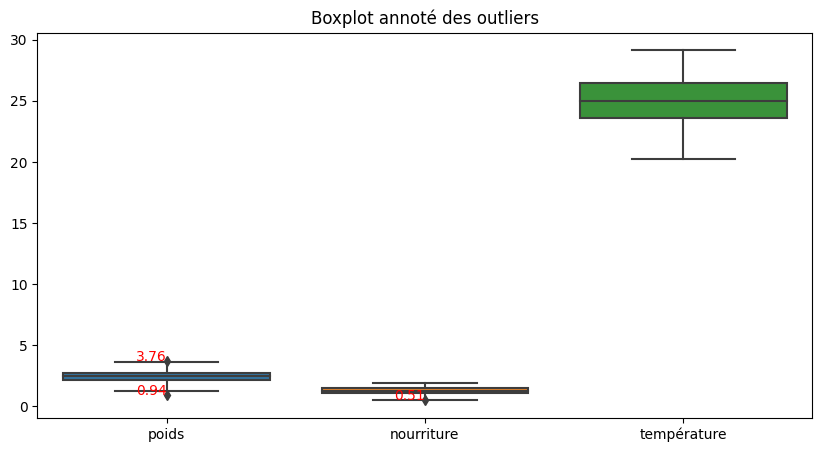

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=data)
plt.title("Boxplot annoté des outliers")
for i, col in enumerate(data.columns):
    outlier_values = data[col][outliers_iqr[col]]
    for value in outlier_values:
        plt.text(i, value, f"{value:.2f}", ha='right', color='red')
plt.show()

- Dans le contexte de données générées aléatoirement, les outliers détectés par les méthodes IQR et Z-score sont probablement dus à la nature aléatoire des données et non à des erreurs de mesure.  
- Étant donné qu'il n'y a pas de contexte réel ou de connaissance métier spécifique pour interpréter ces données, on conserve les outliers.
-  En effet, il est important de noter que les outliers peuvent être des valeurs significatives à ne pas négliger, reflétant la variabilité naturelle des données ou des cas exceptionnels.
- Leur exclusion pourrait fausser l'analyse et les modèles statistiques, car on supprime une partie de l'information disponible.


## Exercice 3 : Tests paramétriques (4 points)

### 5. (2 pts) Testez la normalité des variables (poids, nourriture, température) avec le test de Shapiro Wilk. Expliquez ce que vous observez.

In [35]:
alpha = 0.05  # seuil de signification

for col in ['poids', 'nourriture', 'température']:
    shapiro_test = stats.shapiro(data[col])
    print(f"Test de Shapiro-Wilk pour la variable {col}:")
    print(f"Statistique de test : {shapiro_test.statistic}")
    print(f"p-value : {shapiro_test.pvalue}")

    if shapiro_test.pvalue > alpha:
        print("On ne rejette pas l'hypothèse nulle. La variable suit une loi normale.")
    else:
        print("On rejette l'hypothèse nulle. La variable ne suit pas une loi normale.")
    print("-" * 20)


Test de Shapiro-Wilk pour la variable poids:
Statistique de test : 0.9869512915611267
p-value : 0.4343603253364563
On ne rejette pas l'hypothèse nulle. La variable suit une loi normale.
--------------------
Test de Shapiro-Wilk pour la variable nourriture:
Statistique de test : 0.988318681716919
p-value : 0.5319951772689819
On ne rejette pas l'hypothèse nulle. La variable suit une loi normale.
--------------------
Test de Shapiro-Wilk pour la variable température:
Statistique de test : 0.9828478693962097
p-value : 0.2200966626405716
On ne rejette pas l'hypothèse nulle. La variable suit une loi normale.
--------------------


### 6. (2 pts) Comparez les moyennes de deux groupes avec le test t de Student, puis utilisez une ANOVA pour comparer les moyennes de plusieurs groupes.Interprétez les résultats.

In [36]:
# Séparation en deux groupes aléatoires
group1 = data.sample(n=50, random_state=42)
group2 = data.drop(group1.index)

t_stat, p_value = stats.ttest_ind(group1['poids'], group2['poids'])
print(f"Test t de Student pour poids : t-stat={t_stat}, p-value={p_value}")

if p_value < 0.05:
  print("Il y a une  difference significative entre les moyennes du group1 et group2.")
else:
  print("Il n'y pas a une  difference significative entre les moyennes du group1 et group2.")


Test t de Student pour poids : t-stat=1.0420868714200666, p-value=0.29993536261613823
Il n'y pas a une  difference significative entre les moyennes du group1 et group2.


In [37]:
# ANOVA (comparaison entre plusieurs groupes)
data['groupe'] = np.random.choice(['A', 'B', 'C'], size=len(data))
anova_result = stats.f_oneway(data[data['groupe'] == 'A']['poids'],
                              data[data['groupe'] == 'B']['poids'],
                              data[data['groupe'] == 'C']['poids'])
print(f"ANOVA pour poids : F-stat={anova_result.statistic}, p-value={anova_result.pvalue}")


if anova_result.pvalue < 0.05:
  print("Il y'a une difference significative entre au moins 2 moyennes des 3 groupes.")
else:
  print("Il n'y pas a une  difference significative entre les moyennes des groupes.")


ANOVA pour poids : F-stat=0.8594948894515703, p-value=0.4265746501677007
Il n'y pas a une  difference significative entre les moyennes des groupes.


# Partie 2 : Réduction de dimensionnalité

## Exercice 4 : Analyse en Composantes Principales (ACP) (3 points)

### 7. (1,5 pts) Implémentez une ACP sans scikit-learn (avec numpy). Calculez la matrice de covariance, les valeurs propres et les vecteurs propres.

In [38]:
data = data[['poids', 'nourriture', 'température']]

# Centrer les données
data_centered = data - data.mean()

# Calculer la matrice de covariance
covariance_matrix = np.cov(data_centered, rowvar=False)

# Calculer les valeurs propres et les vecteurs propres
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Afficher les résultats
print("Matrice de covariance :\n", covariance_matrix)
print("\nValeurs propres :\n", eigenvalues)
print("\nVecteurs propres :\n", eigenvectors)


Matrice de covariance :
 [[ 2.71976396e-01 -9.09716216e-03 -4.50171156e-02]
 [-9.09716216e-03  9.27074011e-02 -2.90455401e-04]
 [-4.50171156e-02 -2.90455401e-04  4.62034818e+00]]

Valeurs propres :
 [4.62081418 0.27197231 0.09224548]

Vecteurs propres :
 [[ 1.03508826e-02 -9.98660660e-01 -5.06926470e-02]
 [ 4.33461913e-05  5.06958110e-02 -9.98714140e-01]
 [-9.99946427e-01 -1.03353755e-02 -5.68034526e-04]]


### 8. (1,5 pts) Projetez les données sur les deux premières composantes principales et visualisez le résultat. Combien de composantes gardez-vous ? Justifiez.

In [39]:
# Trier les valeurs propres par ordre décroissant
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [40]:
# Calculer la variance expliquée par chaque composante principale
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
explained_variance_ratio

array([0.92693772, 0.05455779, 0.01850449])

In [41]:
# Projeter les données sur les deux premières composantes principales
projected_data = (data_centered @ eigenvectors[:, :2]).to_numpy()

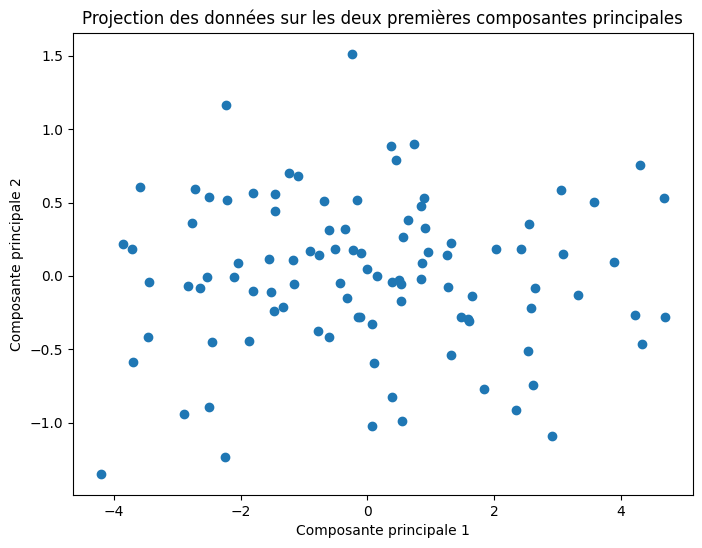

In [42]:
# Visualiser le résultat
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1])
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Projection des données sur les deux premières composantes principales")
plt.show()

In [43]:
# Déterminer le nombre de composantes à garder
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print("Variance expliquée cumulée :", cumulative_variance_ratio)

Variance expliquée cumulée : [0.92693772 0.98149551 1.        ]


- On garde 2 composantes
- On choisit le nombre minimal de composantes qui expliquent une part suffisante de la variance totale des données. Dans ce cas, on cherche à conserver 95% de la variance.  
-Le choix de 95% est arbitraire et peut être ajusté en fonction du contexte de l'étude.


## Exercice 5 : ACP à Noyau (3 points)

### 9. (1,5 pts) Appliquez KernelPCA (avec scikit-learn) sur les données et testez différents noyaux (linéaire, RBF, polynomial).

Variance expliquée par KernelPCA avec noyau linear: [1.0697554  1.00041718]


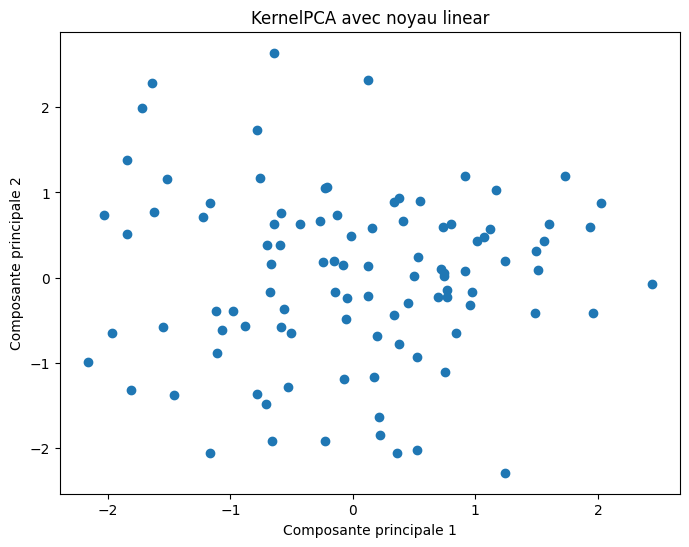

Variance expliquée par KernelPCA avec noyau rbf: [0.11743725 0.09894966]


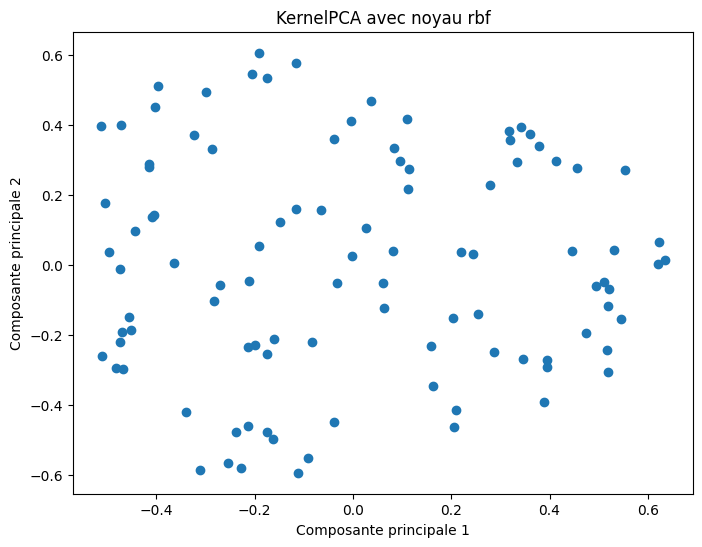

Variance expliquée par KernelPCA avec noyau poly: [2.12846514 1.73632195]


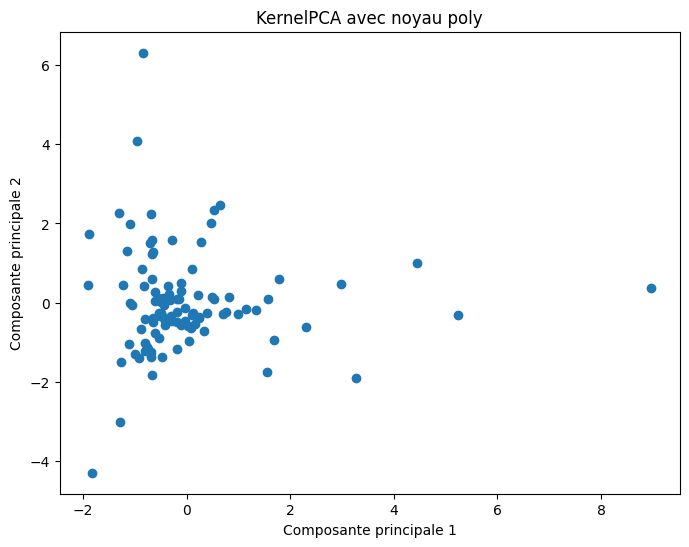

In [44]:
# Standardiser les données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Définir les noyaux à tester
kernels = ['linear', 'rbf', 'poly']

# Appliquer KernelPCA pour chaque noyau
for kernel in kernels:
    kpca = KernelPCA(n_components=2, kernel=kernel)
    data_kpca = kpca.fit_transform(data_scaled)
    explained_variance_kpca = np.var(data_kpca, axis=0)
    print(f"Variance expliquée par KernelPCA avec noyau {kernel}: {explained_variance_kpca}")
    # Afficher les résultats
    plt.figure(figsize=(8, 6))
    plt.scatter(data_kpca[:, 0], data_kpca[:, 1])
    plt.xlabel("Composante principale 1")
    plt.ylabel("Composante principale 2")
    plt.title(f"KernelPCA avec noyau {kernel}")
    plt.show()


### 10. (1,5 pts) Comparez les résultats avec l'ACP classique. Dans quels cas l’ACP à noyau donne-t elle de meilleurs résultats ?

- L'ACP à noyau permet de visualiser des structures non linéaires dans les données, ce qui n'est pas possible avec une ACP classique.
- L'ACP à noyau est particulièrement utile lorsque les données ne sont pas linéairement séparables.
- Si les données présentent une structure non linéaire (par exemple, des groupes de points en forme de cercle ou de spirale), l'ACP à noyau avec un noyau approprié (par exemple, RBF ou polynomial) peut révéler ces structures et donner une meilleure représentation des données en dimensions réduites.
- Le choix du noyau dépend de la nature des données et de la structure que l'on souhaite mettre en évidence.
  - Noyau linéaire : équivalent à une ACP classique.
  - Noyau RBF :  permet de capturer des structures non-linéaires plus complexes, mais le paramètre gamma doit être ajusté avec soin.
  - Noyau polynomial : adapté aux structures polynomiales dans les données.


# Partie 3 : Méthodes d'ensemble

## Exercice 6 : Bagging (3 points)

### 11. (1,5 pts) Implémentez une forêt aléatoire (RandomForestClassifier) pour prédire la survie des poulets. Analysez les performances (accuracy, F1-score).

In [45]:
df = pd.read_csv('donnees_elevage_poulet.csv')
df.head()

,Poids_poulet_g,Nourriture_consommee_g_jour,Temperature_enclos_C,Humidite_%,Age_poulet_jours,Gain_poids_jour_g,Taux_survie_%,Cout_elevage_FCFA
0,3974,52,27.6,79.3,24,12.0,81.1,2682
1,1660,152,31.7,62.5,42,12.2,89.1,6626
2,2094,186,30.1,64.8,29,18.8,90.4,8424
3,1930,111,29.2,87.0,63,13.8,92.9,1933
4,1895,100,26.1,78.2,21,5.5,93.0,4598


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Poids_poulet_g               200 non-null    int64  
 1   Nourriture_consommee_g_jour  200 non-null    int64  
 2   Temperature_enclos_C         200 non-null    float64
 3   Humidite_%                   200 non-null    float64
 4   Age_poulet_jours             200 non-null    int64  
 5   Gain_poids_jour_g            200 non-null    float64
 6   Taux_survie_%                200 non-null    float64
 7   Cout_elevage_FCFA            200 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 12.6 KB


In [47]:
df.describe()

,Poids_poulet_g,Nourriture_consommee_g_jour,Temperature_enclos_C,Humidite_%,Age_poulet_jours,Gain_poids_jour_g,Taux_survie_%,Cout_elevage_FCFA
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000
mean,2509.580000,129.745000,28.389000,75.132000,66.260000,12.960500,90.05200,5157.960000
std,898.436875,44.006166,2.065724,8.790086,28.185716,4.197378,6.24268,2728.600738
min,821.000000,51.000000,25.000000,60.200000,20.000000,5.000000,80.00000,1001.000000
25%,1810.750000,95.750000,26.600000,67.875000,44.000000,9.700000,84.60000,2757.750000
50%,2481.500000,135.500000,28.500000,76.250000,63.500000,13.000000,90.35000,4670.500000
75%,3356.500000,165.250000,30.300000,82.250000,89.500000,16.600000,96.17500,7383.500000
max,3974.000000,199.000000,31.900000,89.700000,119.000000,20.000000,99.90000,9984.000000


In [48]:
X = df[['Poids_poulet_g', 'Nourriture_consommee_g_jour', 'Temperature_enclos_C', 'Humidite_%', 'Age_poulet_jours', 'Gain_poids_jour_g', 'Cout_elevage_FCFA']]
y = (df['Taux_survie_%'] > 85).astype(int)  # Création d'une variable binaire pour la survie

print("Nombre de class :")
y.value_counts()

Nombre de class :


1    147
0     53
Name: Taux_survie_%, dtype: int64

In [49]:
# Séparer les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser et entrainer the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")


Accuracy: 0.725
F1-score: 0.8405797101449275


### 12. (1,5 pts) Identifiez les variables les plus importantes. Quels attributs influencent le plus la survie des poulets ? Pourquoi ?

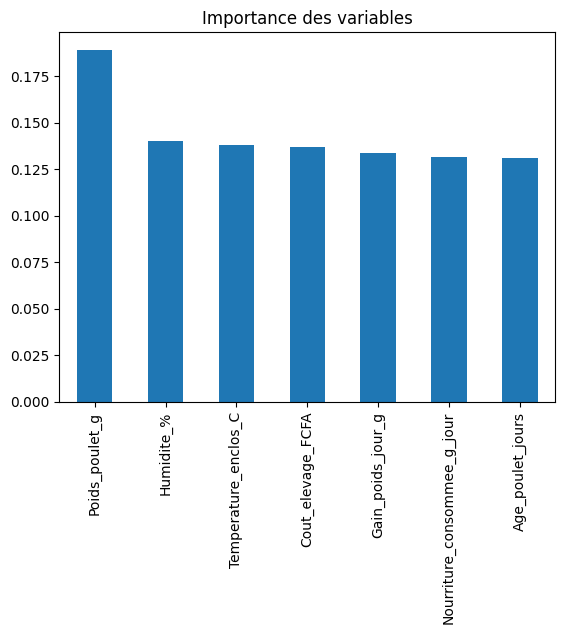

In [50]:
feature_importances = pd.Series(rf_classifier.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', title="Importance des variables")
plt.show()

## Exercice 7 : Boosting (3 points)

### 13. (1,5 pts) Comparez AdaBoost et Gradient Boosting sur la prédiction du gain de poids. Analysez leurs performances.

In [51]:
X = df[['Poids_poulet_g', 'Nourriture_consommee_g_jour', 'Temperature_enclos_C', 'Humidite_%', 'Age_poulet_jours']]
y = df['Gain_poids_jour_g']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

adaboost = AdaBoostRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

adaboost.fit(X_train, y_train)
gb.fit(X_train, y_train)

y_pred_adaboost = adaboost.predict(X_test)
y_pred_gb = gb.predict(X_test)

print(f"MSE AdaBoost: {mean_squared_error(y_test, y_pred_adaboost):.4f}")
print(f"MSE Gradient Boosting: {mean_squared_error(y_test, y_pred_gb):.4f}")

MSE AdaBoost: 30.8263
MSE Gradient Boosting: 36.3082


- On remarque qu'AdaBoost est meilleur en matière de mse

### 14. (1,5 pts) Les deux algorithmes réagissent-ils différemment aux outliers ? Expliquez pourquoi.

In [52]:
outlier_data = df.copy()
outlier_data.loc[0, 'Poids_poulet_g'] = 10000  # Ajout d'un outlier
X_outlier = outlier_data[['Poids_poulet_g', 'Nourriture_consommee_g_jour', 'Temperature_enclos_C', 'Humidite_%', 'Age_poulet_jours']]
y_outlier = outlier_data['Gain_poids_jour_g']

X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_outlier, y_outlier, test_size=0.2, random_state=42)

adaboost.fit(X_train_out, y_train_out)
gb.fit(X_train_out, y_train_out)

y_pred_adaboost_out = adaboost.predict(X_test_out)
y_pred_gb_out = gb.predict(X_test_out)

print(f"MSE AdaBoost avec outliers: {mean_squared_error(y_test_out, y_pred_adaboost_out):.4f}")
print(f"MSE Gradient Boosting avec outliers: {mean_squared_error(y_test_out, y_pred_gb_out):.4f}")


MSE AdaBoost avec outliers: 28.4403
MSE Gradient Boosting avec outliers: 36.3082


- AdaBoost est plus sensible aux outliers.  Il attribue des poids plus importants aux exemples mal classés, et donc les outliers, qui sont souvent mal classés, peuvent avoir une influence disproportionnée sur l'entraînement du modèle.  Un outlier qui est difficile à classer correctement recevra un poids élevé, ce qui amènera l'algorithme à construire des arbres de décision qui lui sont spécifiquement adaptés. Cela peut mener à un modèle suradapté aux outliers et moins performant sur les nouvelles données.

-  Gradient Boosting est moins sensible aux outliers que AdaBoost. Il construit chaque nouvel arbre pour corriger les erreurs résiduelles du modèle précédent. Les outliers, ayant une grande erreur résiduelle, influenceront le nouvel arbre, mais leur influence est atténuée car le gradient est utilisé pour minimiser l'erreur globale et non l'erreur sur un seul exemple.  Le processus de boosting, étape par étape, est moins sensible à de fortes variations dans quelques points de données.  Chaque arbre ne se concentre pas sur la minimisation de l'erreur pour un point particulier mais plutôt sur la minimisation de l'erreur globale de l'ensemble du modèle.

- En résumé, AdaBoost est plus susceptible de se faire piéger par les outliers, alors que Gradient Boosting les prend en compte tout en minimisant leur impact global sur le modèle.
